# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [93]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Loading the data

In [94]:
import datasets

train_test_ds= datasets.load_from_disk("../data/processed_data") #load in the tokenized dataset

train_df = pd.DataFrame(train_test_ds["train"])[["tweet","labels"]] #forget everything except tweets and labels
test_df = pd.DataFrame(train_test_ds["test"])[["tweet","labels"]]

last_train_index = train_df.index[-1] #basicly save the point where we need to split the index later to get train and test sets back
df = train_df.append(test_df)

<AxesSubplot:>

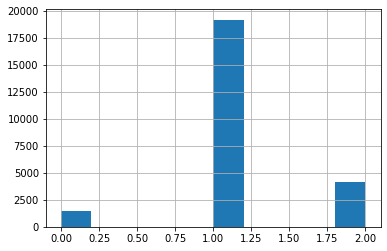

In [95]:
#df = pd.read_csv("../data/labeled_data.csv")
#df.describe()
#print(df.columns)
df['labels'].hist()

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [96]:
tweets = df.tweet

## Feature generation

In [97]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [98]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [99]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

C:\Users\MEGAPORT\nlp\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


In [100]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [101]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [102]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [103]:
#Now join them all up
M = np.concatenate([tfidf,pos],axis=1)

In [104]:
M.shape

(24783, 4006)

In [105]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [106]:
X = pd.DataFrame(M)
y = df.labels

In [107]:
X_train = X.iloc[:last_train_index] # the data was split in datapipeline so we just need to not mix it and apply the same transformation as Davidson
y_train = y.iloc[:last_train_index]
X_test = X.iloc[last_train_index:]
y_test = y.iloc[last_train_index:]

In [108]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [109]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01,solver="liblinear"))
select.fit(X_train,y_train)

X_train_ = select.transform(X_train)
X_test_ = select.transform(X_test)

In [110]:
#model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_, y)
model = LogisticRegression(class_weight='balanced',penalty='l2',C=0.01).fit(X_train_,y_train)

C:\Users\MEGAPORT\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [111]:

y_preds = model.predict(X_test_)

## Evaluating the results

In [112]:
report = classification_report( y_test, y_preds )



In [113]:
def report_to_df(report:str):
    arr = report.split()
    class2name = {0:"hateful",1:"offensive",2:"neither"}
    cls_cols = ["class"] + arr[0:4] # split of column names and add column name class
    avg_cols = ["metric"]  + arr[0:4]
    num_of_classes = 3
    num_of_col = 5

    cls_rows = arr[4:4+num_of_classes*(num_of_col)]
    avg_rows = arr[4+num_of_classes*(num_of_col):]

    def handle_classifer_row(cls_rows): # this changes with the number of classes
        cls_rows = [float(el)  for el in cls_rows]
        cls_rows = [cls_rows[num_of_col*i:num_of_col*(i+1)] for i in range(num_of_classes)] #basicly index stuff
        cls_data = []
        for i in range(num_of_classes): # change class_id to to class_name via class2name for every class
            cls = cls_rows[i][0]
            name = class2name[cls]
            cls_rows[i][0] = name
            cls_data.append(cls_rows[i])
        return cls_data

    def handle_average_rows(avg_rows): # this can be completely hardcoded since this never changes with size!
        acc_row = avg_rows[0:3]
        acc_name = acc_row[0] # this row is different than the other two since it contains more whitespace
        acc_row = acc_row[1:]
        acc_row = [float(el) for el in acc_row]
        acc_row = [acc_name] + [np.nan,np.nan] + acc_row # fixing acc_row so it looks like every other row

        macro_row = avg_rows[3:9]
        macro_name = macro_row[0] + macro_row[1] # whitespace in "macro avg" creates two elements
        macro_row = macro_row[2:]
        macro_row = [float(el) for el in macro_row]
        macro_row = [macro_name] + macro_row #put everything together so numbers are floats and name is at index 0

        weighted_row = avg_rows[9:]
        weighted_name = weighted_row[0] + weighted_row[1] #same as above
        weighted_row = weighted_row[2:]
        weighted_row = [float(el) for el in weighted_row]
        weighted_row = [weighted_name] + weighted_row

        avg_data = [acc_row,macro_row,weighted_row]
        return avg_data

    cls_data = handle_classifer_row(cls_rows)
    avg_data = handle_average_rows(avg_rows)
    cls_df = pd.DataFrame(data = cls_data , columns = cls_cols).set_index("class")
    avg_df = pd.DataFrame(data = avg_data , columns = avg_cols).set_index("metric")
    return cls_df,avg_df

def report_to_LaTeX(report,mode=None):
    cls_df,avg_df = report_to_df(report)
    begin_str = "\\begin{center}\n\\begin{tabular}{c| c c c c}\n"
    end_str = "\\end{tabular}\n\\end{center}\n"

    def build_TeX(df,index_str):
        cols  = list(df.columns)
        out_str= index_str

        for el in cols:
            out_str = out_str + " & " + str(el)
        out_str = out_str + " \\\\" + "\n" + "\\hline" + "\n"

        for row in df.iterrows():
            class_name = row[0]
            row_str = class_name
            data = list(row[1])
            for el in data:
                row_str = row_str + " & " + str(el)
            row_str = row_str + " \\\\" + "\n"
            out_str = out_str + row_str
        return begin_str + out_str + end_str
     
    cls_TeX = build_TeX(cls_df,"class")
    avg_TeX = build_TeX(avg_df,"metric")
    if mode == "save":
        with open("../report/nofeat_cls_table.txt","w") as output_file:
            output_file.write(cls_TeX)
        with open("../report/nofeat_avg_table.txt","w") as output_file:
            output_file.write(avg_TeX)
    else:
        return cls_TeX,avg_TeX

report_to_LaTeX(report,"save")

***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

In [114]:
print(report)

              precision    recall  f1-score   support

           0       0.20      0.61      0.30       134
           1       0.95      0.73      0.83      1900
           2       0.62      0.83      0.71       446

    accuracy                           0.74      2480
   macro avg       0.59      0.72      0.61      2480
weighted avg       0.85      0.74      0.78      2480



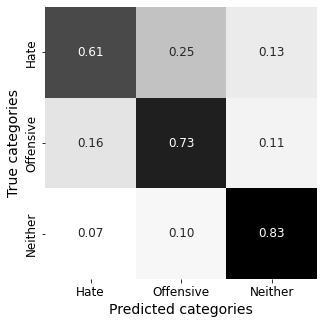

In [115]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('../report/nofeat_confusion.jpg')

<AxesSubplot:>

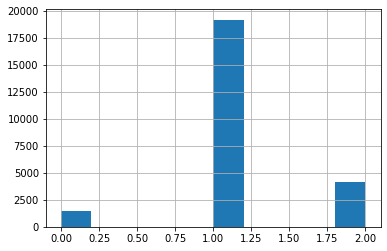

In [116]:
#True distribution
y.hist()

<AxesSubplot:>

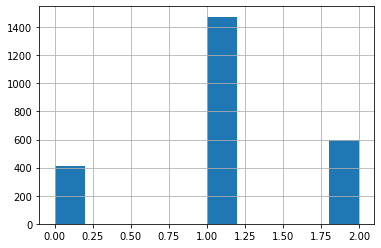

In [117]:
pd.Series(y_preds).hist()